Implementation of the boosting algorithm [Boosting a decision stump](Boosting a decision stump) using **Gradient Boosting Machine** instead of AdaBoost.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

# Load data of loans and data preprocessing. 
This is a binary classification problem and we need to determine whether a loan is safe or bad.

In [5]:
loans = pd.read_csv('../../Data/lending-club-data.csv')
loans['safe_loans'] = loans['bad_loans'].map({0: +1, 1: -1}) # in binomial deviance loss, we need label +1 and -1
loans.drop('bad_loans', axis=1, inplace=True)
# for simplification, we only consider four features
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home_ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
target = 'safe_loans'
loans = loans[features + [target]]
loans.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,grade,term,home_ownership,emp_length,safe_loans
0,B,36 months,RENT,10+ years,1
1,C,60 months,RENT,< 1 year,-1
2,C,36 months,RENT,10+ years,1
3,C,36 months,RENT,10+ years,1
4,A,36 months,RENT,3 years,1


In [6]:
# take all the features as categorical ones and apply one-hot encoding
loans = pd.get_dummies(loans)
# get the new feature names
features = list(loans)
features.remove(target)
features

['grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'term_ 36 months',
 'term_ 60 months',
 'home_ownership_MORTGAGE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year']

## Balance the two classes in the dataset

In [8]:
# here we use the index provided by the lecturer
import json
train_idx_file = '../../data/module-5-assignment-2-train-idx.json'
test_idx_file = '../../data/module-5-assignment-2-test-idx.json'
with open(train_idx_file) as f:
    train_idx = json.load(f)
with open(test_idx_file) as f:
    test_idx = json.load(f)
train_data = loans.iloc[train_idx, :]
test_data = loans.iloc[test_idx, :]
print('train shape: ', train_data.shape, '. \nValue counts: \n', train_data['safe_loans'].value_counts())
print('test shape: ', test_data.shape, '. \nValue counts: \n', test_data['safe_loans'].value_counts())

train shape:  (37224, 25) . 
Value counts: 
  1    18748
-1    18476
Name: safe_loans, dtype: int64
test shape:  (9284, 25) . 
Value counts: 
 -1    4674
 1    4610
Name: safe_loans, dtype: int64


# Decision stump
The most simple decision tree with only two terminal nodes. **Because the gradient is continuous instead of binary, the decision stump should be a regression tree.**
Here, we use the variance metric to find the splitting variable and splitting value.
Note that all the features are discrete ones (0 or 1 after one-hot encoding)

In [9]:
def Gini_index(t):
    # given the target vector t (1 or -1) of a set of samples, compute the Gini index
    n = len(t)
    if n == 0:
        return 0
    n1 = (t == 1).sum() # number of samples belonging to class 1
    n2 = (t == -1).sum() # number of samples in class -1
    return 1 - (n1/n)**2 - (n2/n)**2 

In [10]:
# In this decision stump, since each feature can only be 0 or 1, we assign the samples to the left terminal or right terminal accordingly.
def find_splitting_feature(data, features, target):
    best_feature = None # the one leading to maximum Gini index decrease (like information gain)
    min_obj = float('inf')
    for feature in features:
        left_t = data[data[feature] == 0, target]
        right_t = data[data[feature] == 1, target]
        left_GI = Gini_index(left_t)
        right_GI = Gini_index(right_t)
        GI_after_splitting = len(left_t)/len(data)*left_GI + len(right_t)/len(data)*right_GI # weighted sum
        if GI_after_splitting < min_obj:
            best_feature = feature
            min_obj = GI_after_splitting
    return best_feature

In [28]:
class DecisionStump:
    def __init__(self):
        self.splitting_feature = None
        self.left_value = None
        self.right_value = None
    
    def train(self, data, features, target):
        # find the splitting using variance as the metric
        self.splitting_feature = None
        min_obj = float('inf')
        for feature in features:
            left_t = data.loc[data[feature] == 0, target]
            right_t = data.loc[data[feature] == 1, target]
            var = len(left_t)/len(data) * left_t.var() + len(right_t)/len(data) * right_t.var()
            if var < min_obj:
                min_obj = var
                self.splitting_feature = feature
                # the predications of the two leaf nodes are just mean values
                self.left_value = left_t.mean()
                self.right_value = right_t.mean()
    
    def predict(self, X):
        return X[self.splitting_feature].map({0: self.left_value, 1: self.right_value})

# Gradient Boosting Decision Stump
For this binary classification problem, the binomial deviance loss function is used. There are mainly two parameters: the iteration number M and the shrinkage parameter $\lambda$. 

Generally, shrinkage $\lambda$ should be small enough to resist overfitting at the cost of more iterations to generate to more decision stumps.
The fitted additive model is: $f(x) = \sum_{i=1}^{i=M} \lambda T_i(x)$, where $T_i(x)$ is the decision stump we got in the $i^th$ iteration.

In [35]:
class GBDecisionStump:
    def __init__(self, M, shrinkage):
        self.M = M
        self.shrinkage = shrinkage
        self.decision_stumps = [] # list of all the decision stumps by boosting
        
    def train(self, data, features, target):
        self.decision_stumps = []
        N = len(data)
        f = np.zeros(N) # initial model
        y = data[target]
        for i in range(self.M):
            # gradient
            r = 2*y*np.exp(-2*y*f) / (1 + np.exp(-2*y*f))
            data.loc[:, 'gradient'] = r
            # fit a decision stump to the gradient
            ds = DecisionStump()
            ds.train(data, features, 'gradient')
            # update the additive model f
            # we cannot really add two decision stumps. Instead, just store them
            # however, we need the new f value for each input sample
            self.decision_stumps.append(ds)
            f = f + self.shrinkage * ds.predict(data)
    
    def predict(self, X):
        y = np.zeros(len(X))
        for ds in self.decision_stumps:
            y = y + ds.predict(X)
        y = np.sign(y)
        y[y == 0] = -1
        return y  

# Test the Gradient Boosting Decision Stump

In [38]:
gbds = GBDecisionStump(300, 0.02)
gbds.train(train_data, features, target)
p = gbds.predict(train_data)
print('error rate: ', (p != train_data[target]).sum() / len(train_data))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


error rate:  0.382172791747


## error rate curve w.r.t the iteration number

In [39]:
Ms = list(range(1, 1000, 50))
shrinkage = 0.02
train_error_all = []
test_error_all = []
for M in Ms:
    gbds = GBDecisionStump(M, shrinkage)
    gbds.train(train_data, features, target)
    p = gbds.predict(train_data)
    train_error_all.append((p != train_data[target]).sum() / len(train_data))
    p = gbds.predict(test_data)
    test_error_all.append((p != test_data[target]).sum() / len(test_data))
    

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


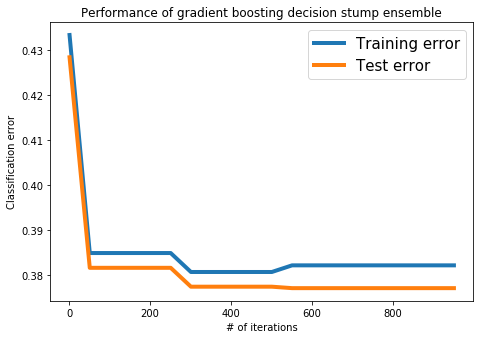

In [40]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(Ms, train_error_all, '-', linewidth=4.0, label='Training error')
plt.plot(Ms, test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of gradient boosting decision stump ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

As we can see, roughly 500 iterations is enough. One characteristic of gradient boosting is its resistance to overfitting. Even at about 1000 iterations, the model is still not overfitting. The plateau is quite wide and therefore a wide range of iterations is acceptable. Compared with the [AdaBoost.M1 algorithm](../../AdaBoost/Boosting a decision stump.ipynb), the performance of GBM is better. However, due to the careless choice of features, the best classification error is around 0.38. 